# Franceschin CERIC beamtime @ SYRMEP Elettra
## Image processing of corroded pit

Sample: 581681_patina/581681_punta_HR_stitch2

Created on:  22.04.2022 <br />
Last update: 23.04.2022 <br />

In [3]:
%%html
<style> table {float:left} </style>

|Scan parameters|   |
|:-|:-|
|Beamline|SYRMEP@Elettra|
|Sample|581681_patina/581681_punta_HR_stitch2 |
|Energy| 27 keV |
|Camera| ORCA flash |
|Voxel size| 1.0 um |
|SDD | 150 mm |
|Preliminary operations|stitch of 4 scans (normalized; 2D rigid transform) |

## Configuration

In [2]:
import sys
sys.path.append('/home/gianthk/PycharmProjects/recon_utils')
sys.path.append('/home/gianthk/PycharmProjects/CT2FE')

In [3]:
# import os
import numpy as np
# import dxchange
import matplotlib
import matplotlib.pyplot as plt
# import logging
# logging.basicConfig(level=logging.INFO)

# import mcubes
from scipy import ndimage, misc
# from skimage.filters import threshold_otsu, gaussian
from skimage import measure, morphology

from recon_utils import read_tiff_stack, plot_midplanes
from pybonemorph import remove_unconnected, remove_largest

astropy module not found
olefile module not found


In [4]:
matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data
loading small portion (100 slices) of the full dataset..

In [5]:
# input_file = '/media/gianthk/My Passport/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/slices/slice_0000.tif'
input_file = '/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/100slices/slice_4101.tif'

In [6]:
data_3D = read_tiff_stack(input_file, [4120, 4150])

In [7]:
vs = np.ones(3)*1.0e-3 # [mm]

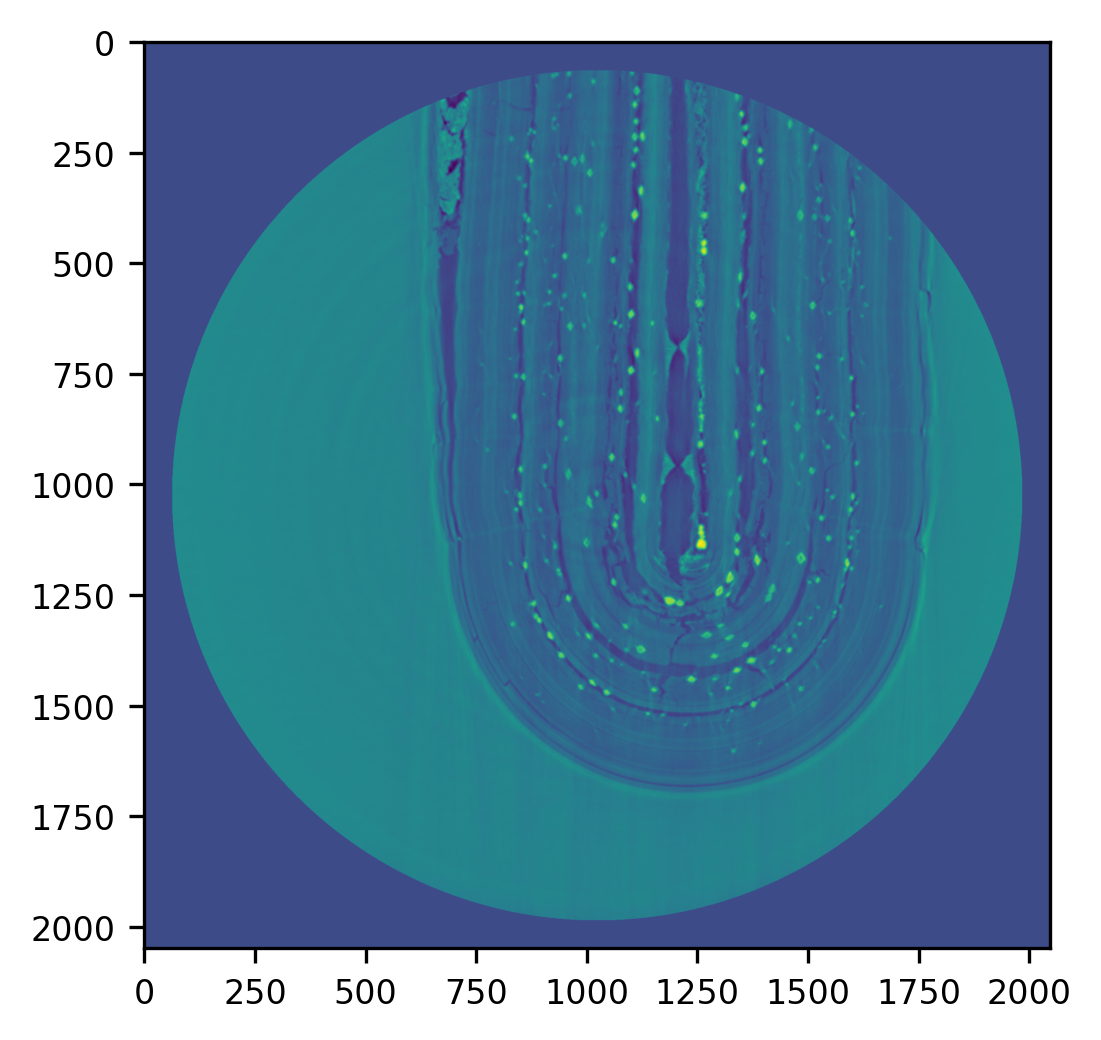

In [8]:
# Inspect slice
plt.imshow(data_3D[20,:,:])

## 1. Pre-processing
### 1.1. Gaussian smooth (don't)

In [8]:
data_3D = gaussian(data_3D, sigma=1, preserve_range=True)

### 1.2. Resize (don't)

In [48]:
resampling = 1.2

# resize the 3D data using spline interpolation of order 2
data_3D = ndimage.zoom(data_3D, 1/resampling, output=None, order=2)

# correct voxelsize
vs = vs * resampling

In [ ]:
# Inspect again the dataset
plot_midplanes(data_3D)
plt.show()

## 2. Sample boundary mask

### 2.0. circle mask

In [9]:
BW_circle = data_3D == 0

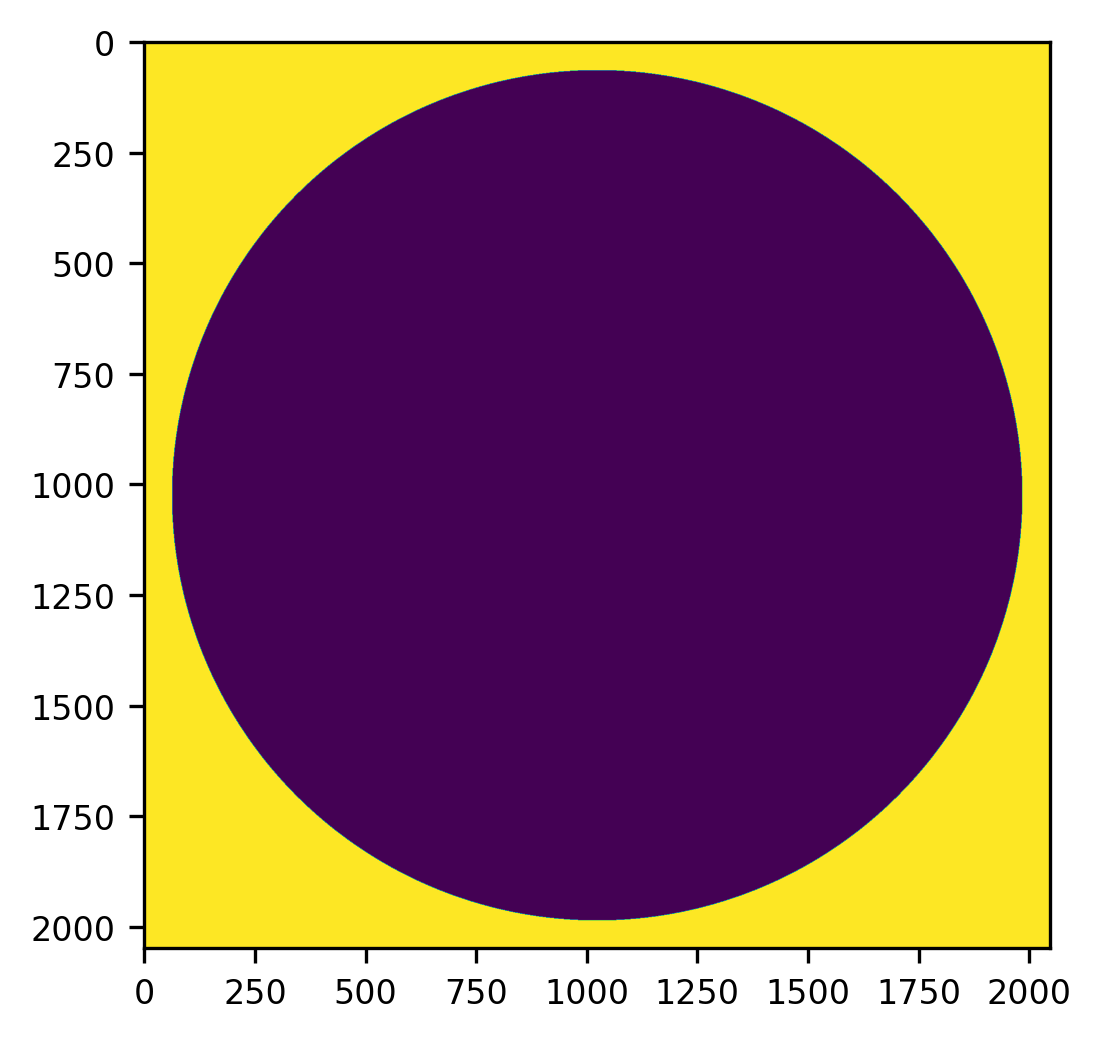

In [10]:
plt.imshow(BW_circle[20,:,:])

### 2.1. pit mask
2.1.1. Filter based on GV

In [27]:
BW_pit = (data_3D>0.000264) & (data_3D<0.00159)

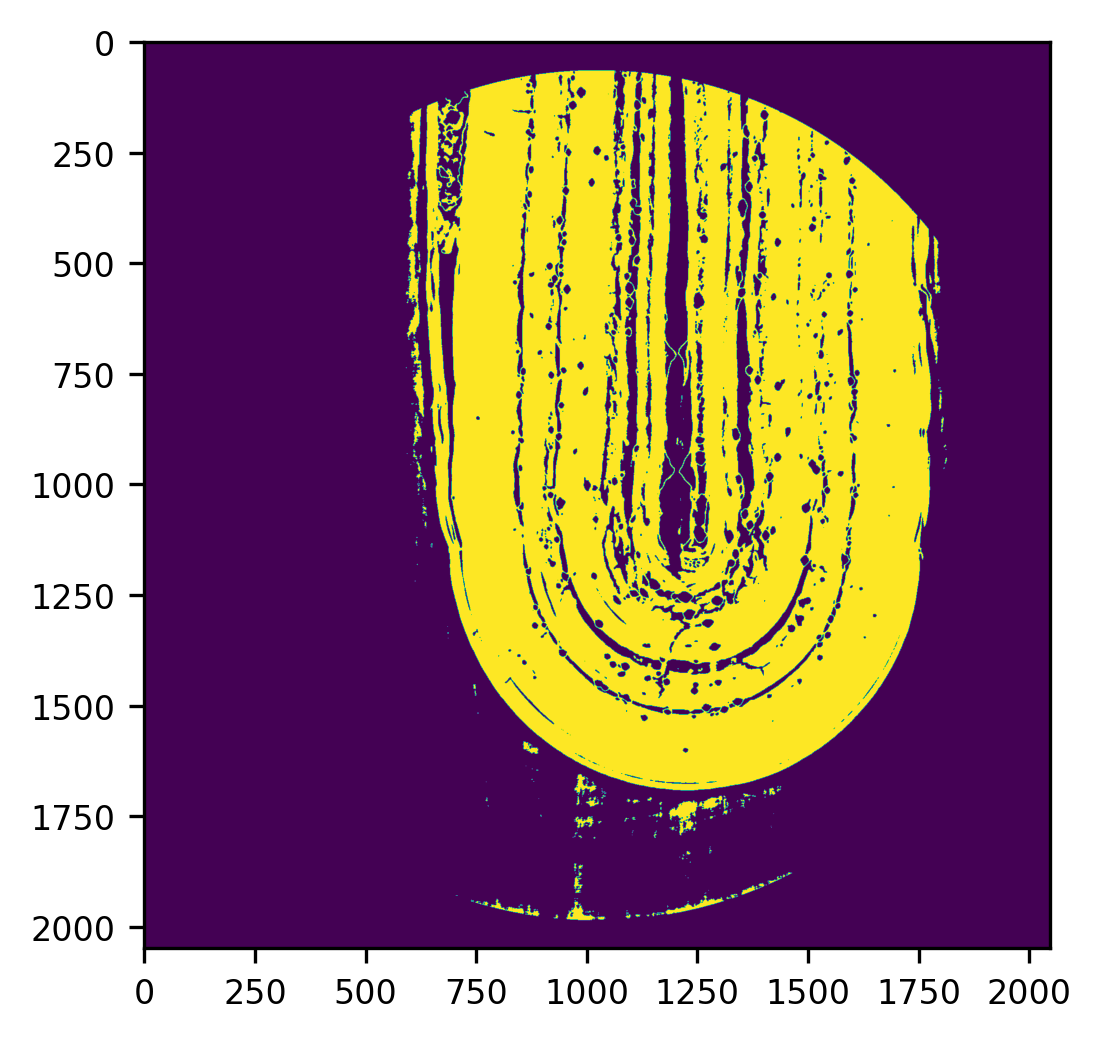

In [28]:
plt.imshow(BW_pit[0,:,:])

2.1.2. Image open to remove circle (don't)

In [9]:
# BW_pit = morphology.binary_opening(BW_pit, morphology.cube(2))

2.1.3. Fill holes within pit (don't)

In [13]:
# BW_pit = ndimage.binary_fill_holes(BW_pit)

2.1.4. Remove unconnected struts

In [29]:
BW_pit = remove_unconnected(BW_pit)

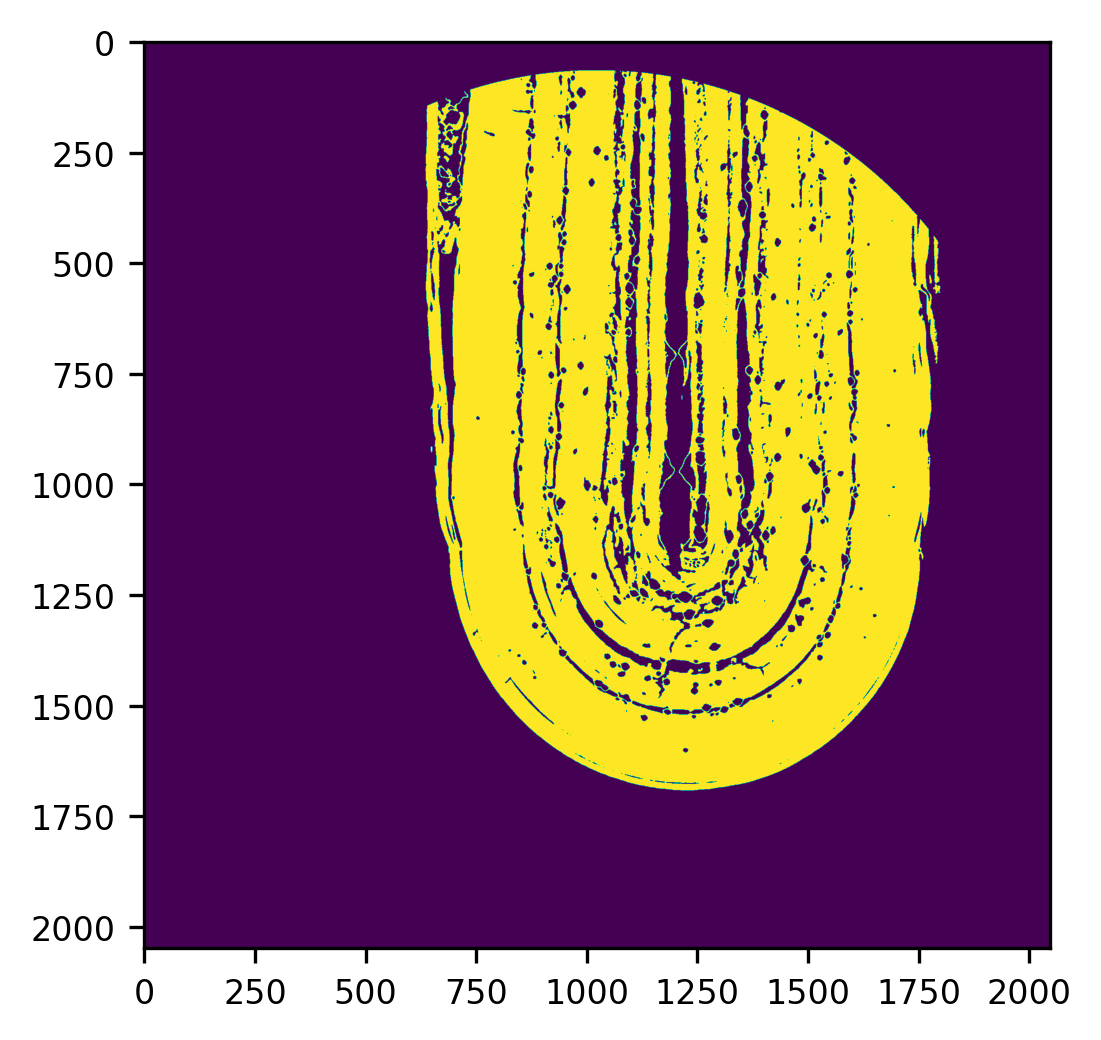

In [30]:
plt.imshow(BW_pit[0,:,:])

2.1.5. Close open surface of the pit with the cirle mask (don't)

In [48]:
# BW_pit2 = BW_pit & morphology.binary_dilation(BW_circle, morphology.cube(5))

In [98]:
# BW_pit2 = ndimage.binary_closing(~(BW_pit | BW_circle), morphology.cube(3), iterations=3 border_value=1)

2.1.6. Find holes within pit

In [31]:
BW_holes_within_pit = remove_largest(~(BW_pit | BW_circle))

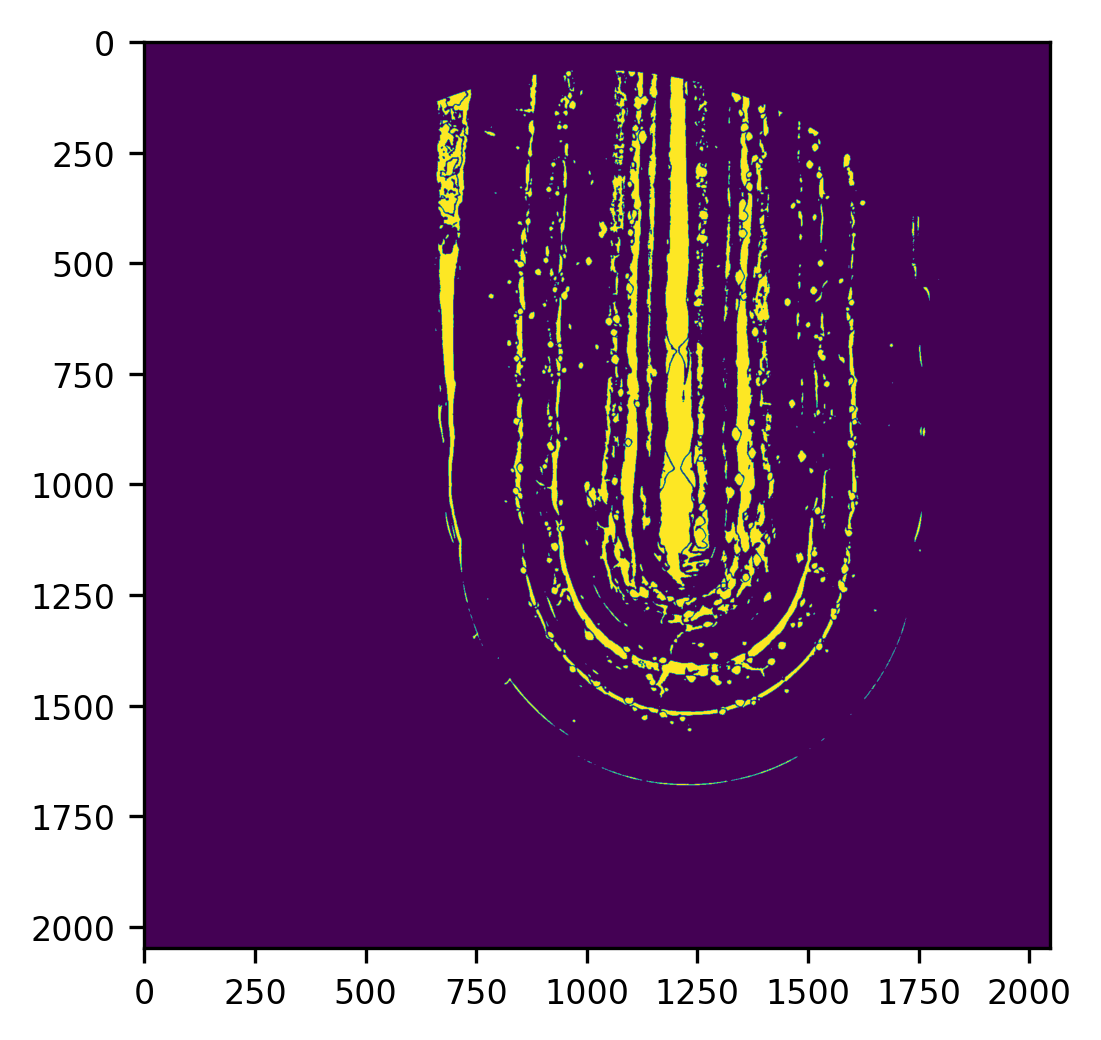

In [32]:
plt.imshow(BW_holes_within_pit[10,:,:])

2.1.7. Pit mask (holes removed)

In [33]:
BW_pit = BW_pit | BW_holes_within_pit

2.1.8. Image closing (optional)

In [103]:
BW_pit = ndimage.binary_closing(BW_pit, morphology.ball(1), iterations=5, border_value=1)

2.1.9. Followed by holes removal

In [104]:
BW_pit = ~remove_unconnected(~BW_pit)

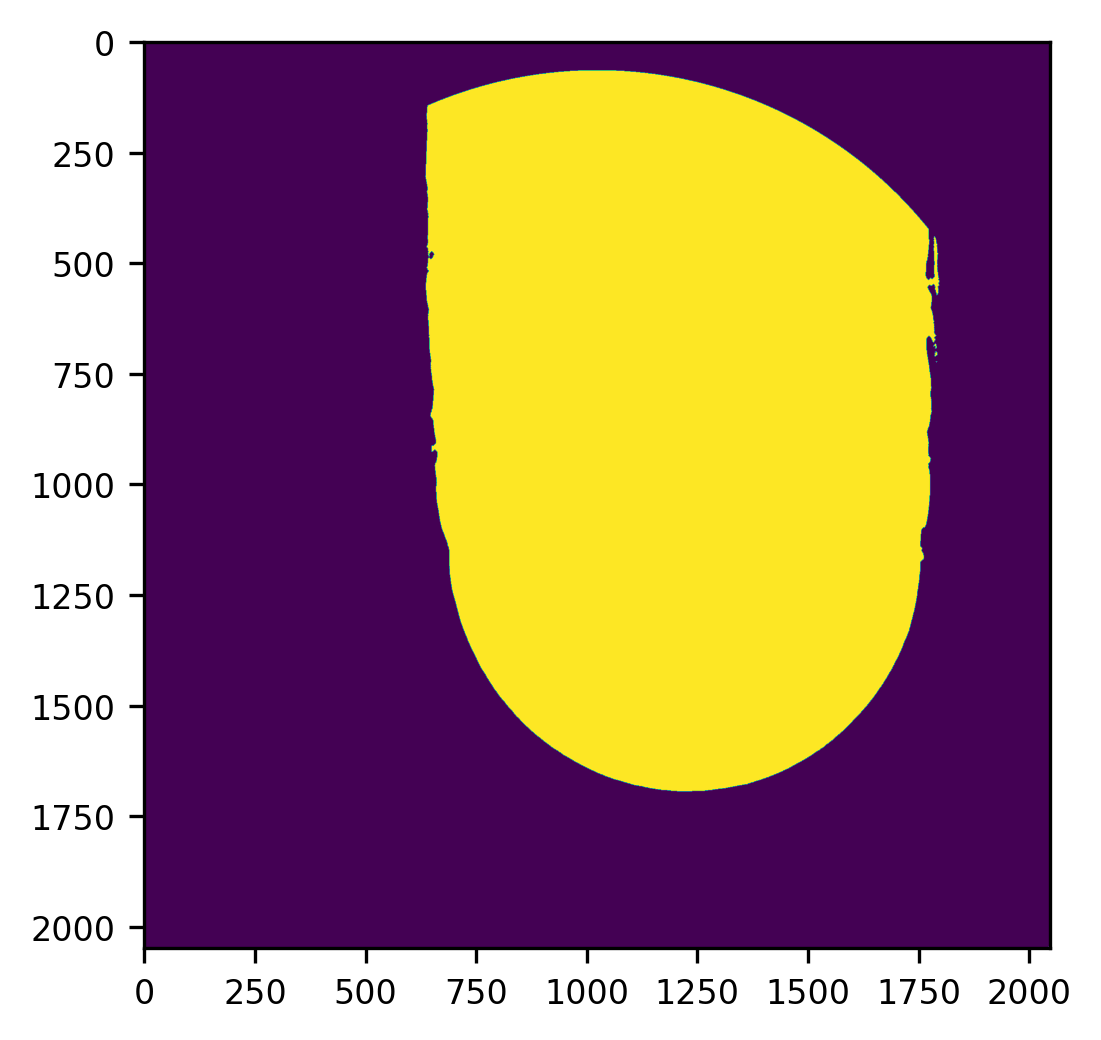

In [117]:
plt.imshow(BW_pit[7,:,:])

### 2.2. Pit boundary mask

In [108]:
BW_pit_boundary = BW_pit & ~ndimage.binary_erosion(BW_pit, morphology.ball(1), border_value=1)

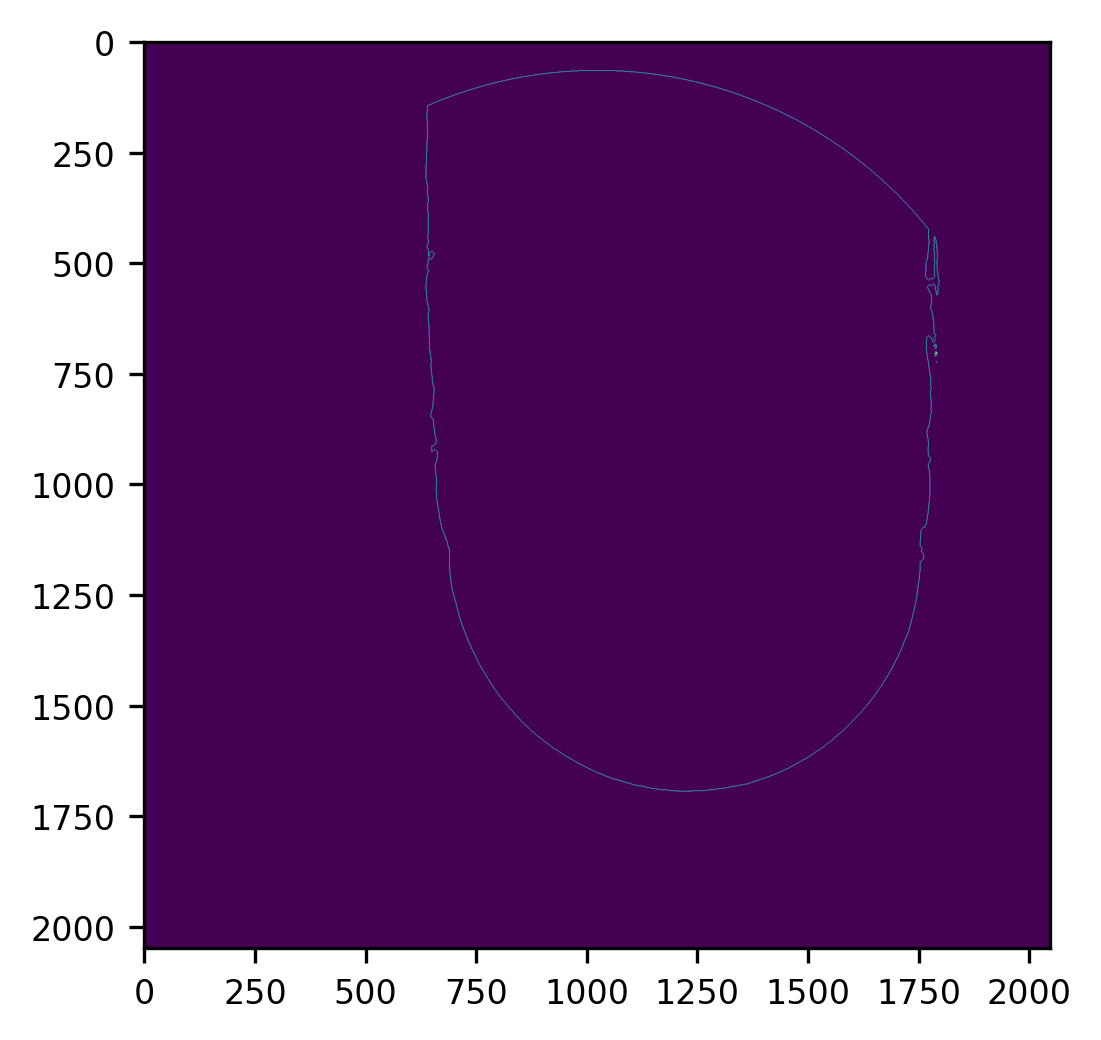

In [118]:
plt.imshow(BW_pit_boundary[7,:,:])

## 3. Mask perline
3.1. Select highly mineralized regions from their GV (brightest histogram tail..)

In [131]:
BW_pearls = data_3D>0.0022

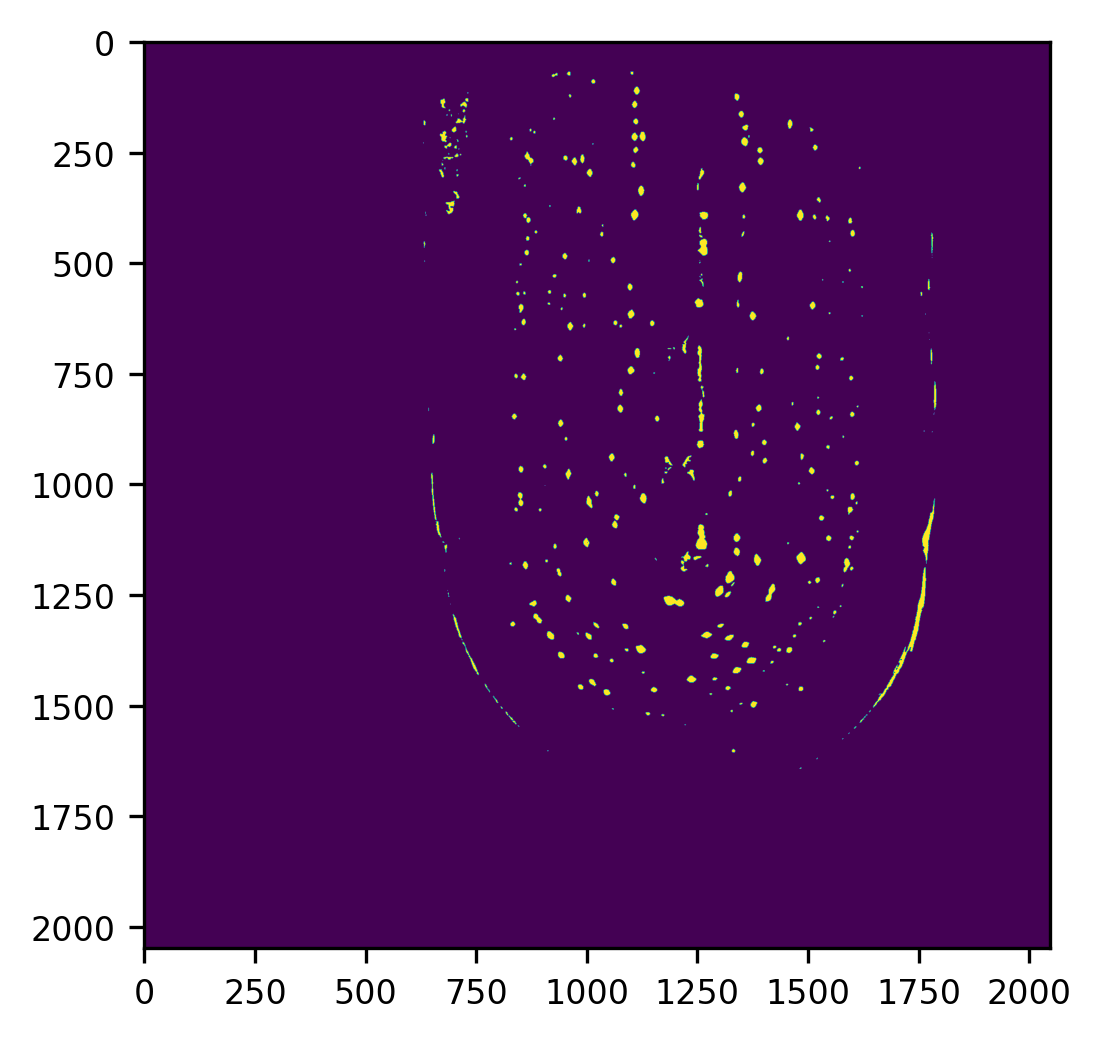

In [133]:
plt.imshow(BW_pearls[20,:,:])

3.2. Remove outer pit stuff by applying eroded pit mask

In [134]:
BW_pearls = BW_pearls & ndimage.binary_erosion(BW_pit, morphology.ball(1), iterations=30, border_value=1)

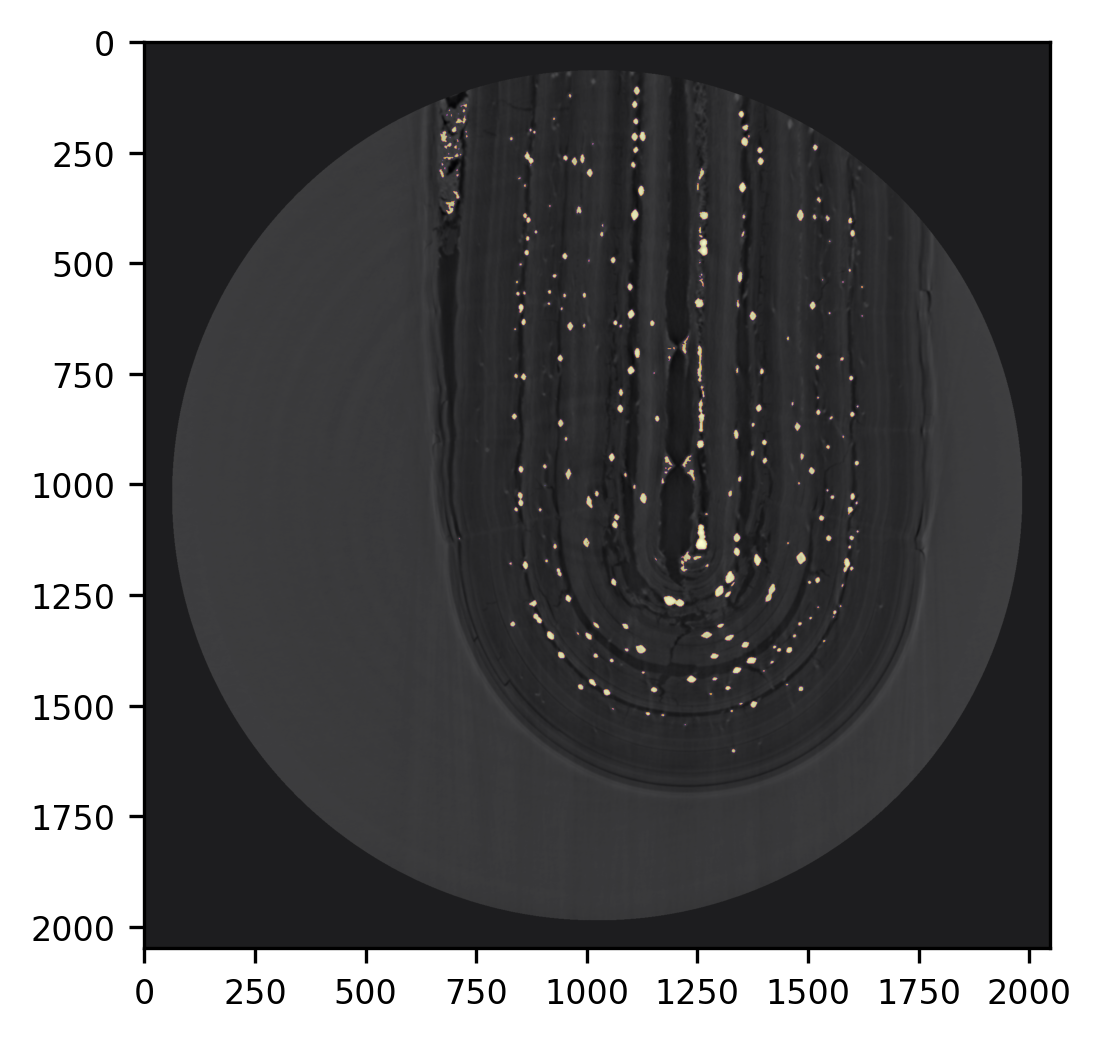

In [139]:
plt.imshow(data_3D[20,:,:], cmap='gray')
plt.imshow(BW_pearls[20,:,:], cmap='inferno', alpha=0.5)

### 3.3. apply watershed or snow algorithm to separate glued pearls
(not implemented yet..)

## 4.0. regionprops pearls
4.1. Apply scikit image labelling

In [140]:
regions = ndimage.label(BW_pearls)[0]

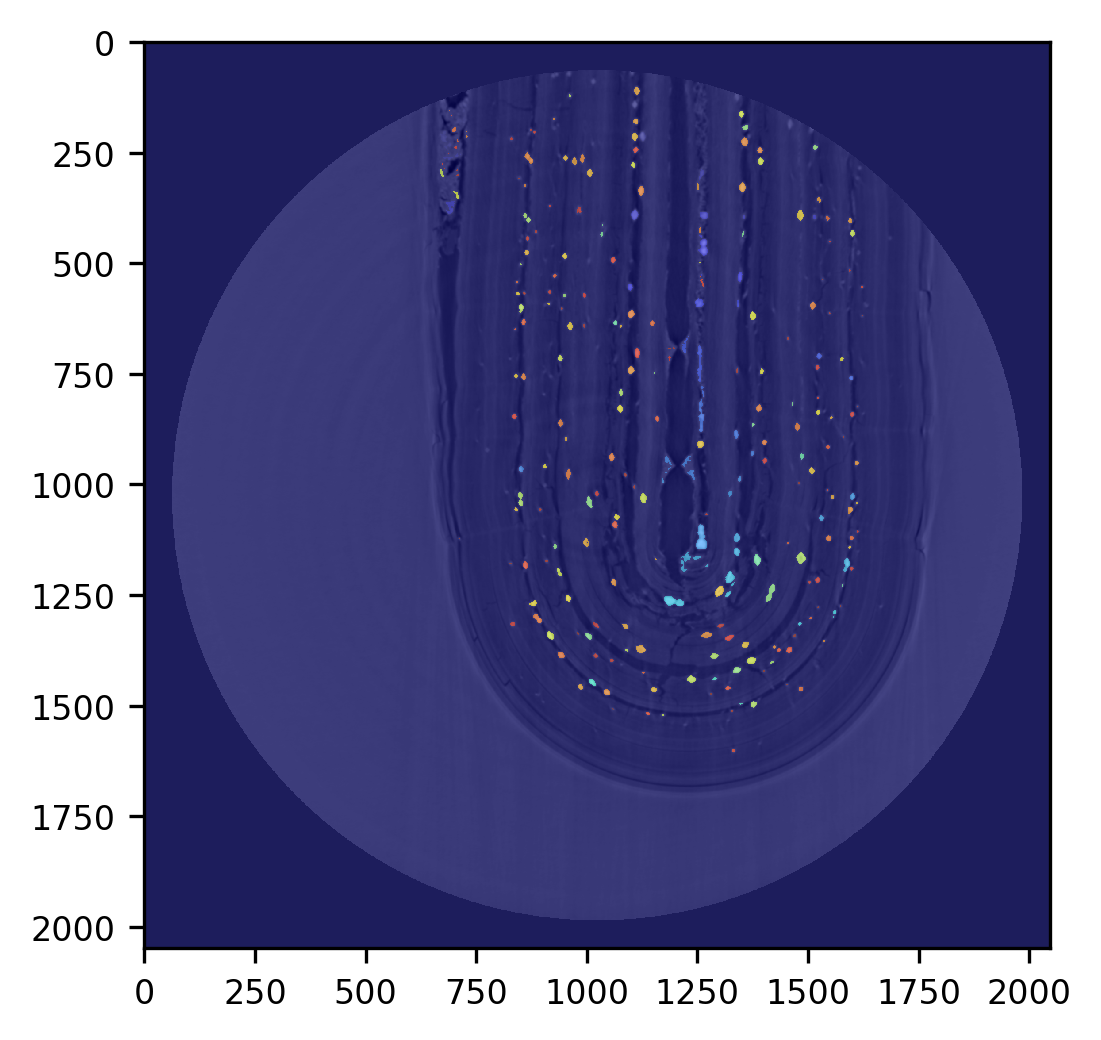

In [153]:
plt.imshow(data_3D[20,:,:], cmap='gray', interpolation='none')
plt.imshow(regions[20,:,:], cmap='jet', alpha=0.5, interpolation='none') # 'tab20c'

4.2. porespy regionprops_3D 

props is a list of RegionProperties objects, subclassed from scikit-image. Each RegionProperties object possess the properties as attributes. Note that these are calculated on demand, so the regionsprops_3D function appears very quick, but the work has not yet been done.

In [156]:
import porespy as ps

In [157]:
props = ps.metrics.regionprops_3D(regions)

Inspecting some of the props for specific pearls..

In [176]:
print(props[20].volume)

772


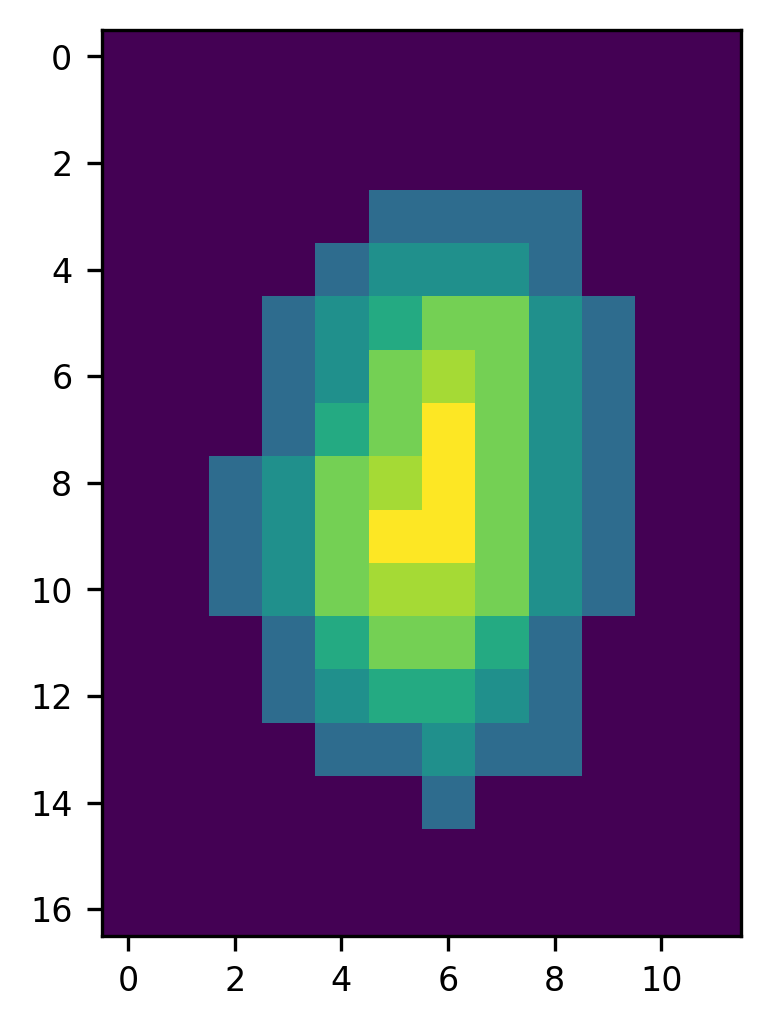

In [165]:
plt.imshow(props[20].dt[5, ...]);

4.3. Create dataframe of the measured props

In [166]:
df = ps.metrics.props_to_DataFrame(props)

/home/gianthk/anaconda3/envs/porespy/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 462731300  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  3  Error-roundoff 4e-15  _one-merge 2.8e-14  _near-inside 1.4e-13
  Visible-distance 8.1e-15  U-max-coplanar 8.1e-15  Width-outside 1.6e-14
  _wide-facet 4.8e-14  _maxoutside 3.2e-14

  return convex_hull_image(self.image)
/home/gianthk/anaconda3/envs/porespy/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhull 

/home/gianthk/anaconda3/envs/porespy/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 462764914  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  5  Error-roundoff 6.5e-15  _one-merge 4.5e-14
  _near-inside 2.3e-13  Visible-distance 1.3e-14  U-max-coplanar 1.3e-14
  Width-outside 2.6e-14  _wide-facet 7.8e-14  _maxoutside 5.2e-14

  return convex_hull_image(self.image)
/home/gianthk/anaconda3/envs/porespy/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6214 qhull input error: not enough points(2) to construct initial simplex (need 4)

While executing:  | qhul

/home/gianthk/anaconda3/envs/porespy/lib/python3.9/site-packages/skimage/measure/_regionprops.py:395: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 462781721  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  2  Error-roundoff 2.5e-15  _one-merge 1.7e-14
  _near-inside 8.6e-14  Visible-distance 4.9e-15  U-max-coplanar 4.9e-15
  Width-outside 9.8e-15  _wide-facet 3e-14  _maxoutside 2e-14

The input to qhull appears to be less than 3 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p1(v4):     0     1     0
- p4(v3):     1     2     0
- p2(v2):     1     0     0
- p0(v1):     0     0     0

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring fa

2022-04-23 18:51:44 | ERROR    | porespy.metrics._regionprops:props_to_DataFrame:69
--> Error encountered evaluating feret_diameter_max so skipping it
2022-04-23 18:51:44 | ERROR    | porespy.metrics._regionprops:props_to_DataFrame:69
--> Error encountered evaluating axis_minor_length so skipping it


In [168]:
df.head()

,label,volume,bbox_volume,sphericity,surface_area,convex_volume,area,area_bbox,area_convex,equivalent_diameter_area,euler_number,extent,area_filled,axis_major_length,solidity
0,1,1481,3960,0.926409,678.242310,1606,1481,3960,1606,14.142260,1,0.373990,1481,20.190025,0.922167
1,2,241,588,0.666929,280.812256,356,241,588,356,7.720987,1,0.409864,241,16.483868,0.676966
2,3,8023,31465,0.616060,3145.953613,12952,8023,31465,12952,24.837777,1,0.254982,8023,42.223853,0.619441
3,4,6252,47040,0.285448,5749.574707,30079,6252,47040,30079,22.856345,-3,0.132908,6252,66.770040,0.207853
4,5,2599,5400,0.932710,980.110840,2816,2599,5400,2816,17.058305,1,0.481296,2599,19.491430,0.922940


4.4. Take a look at the histograms of various props

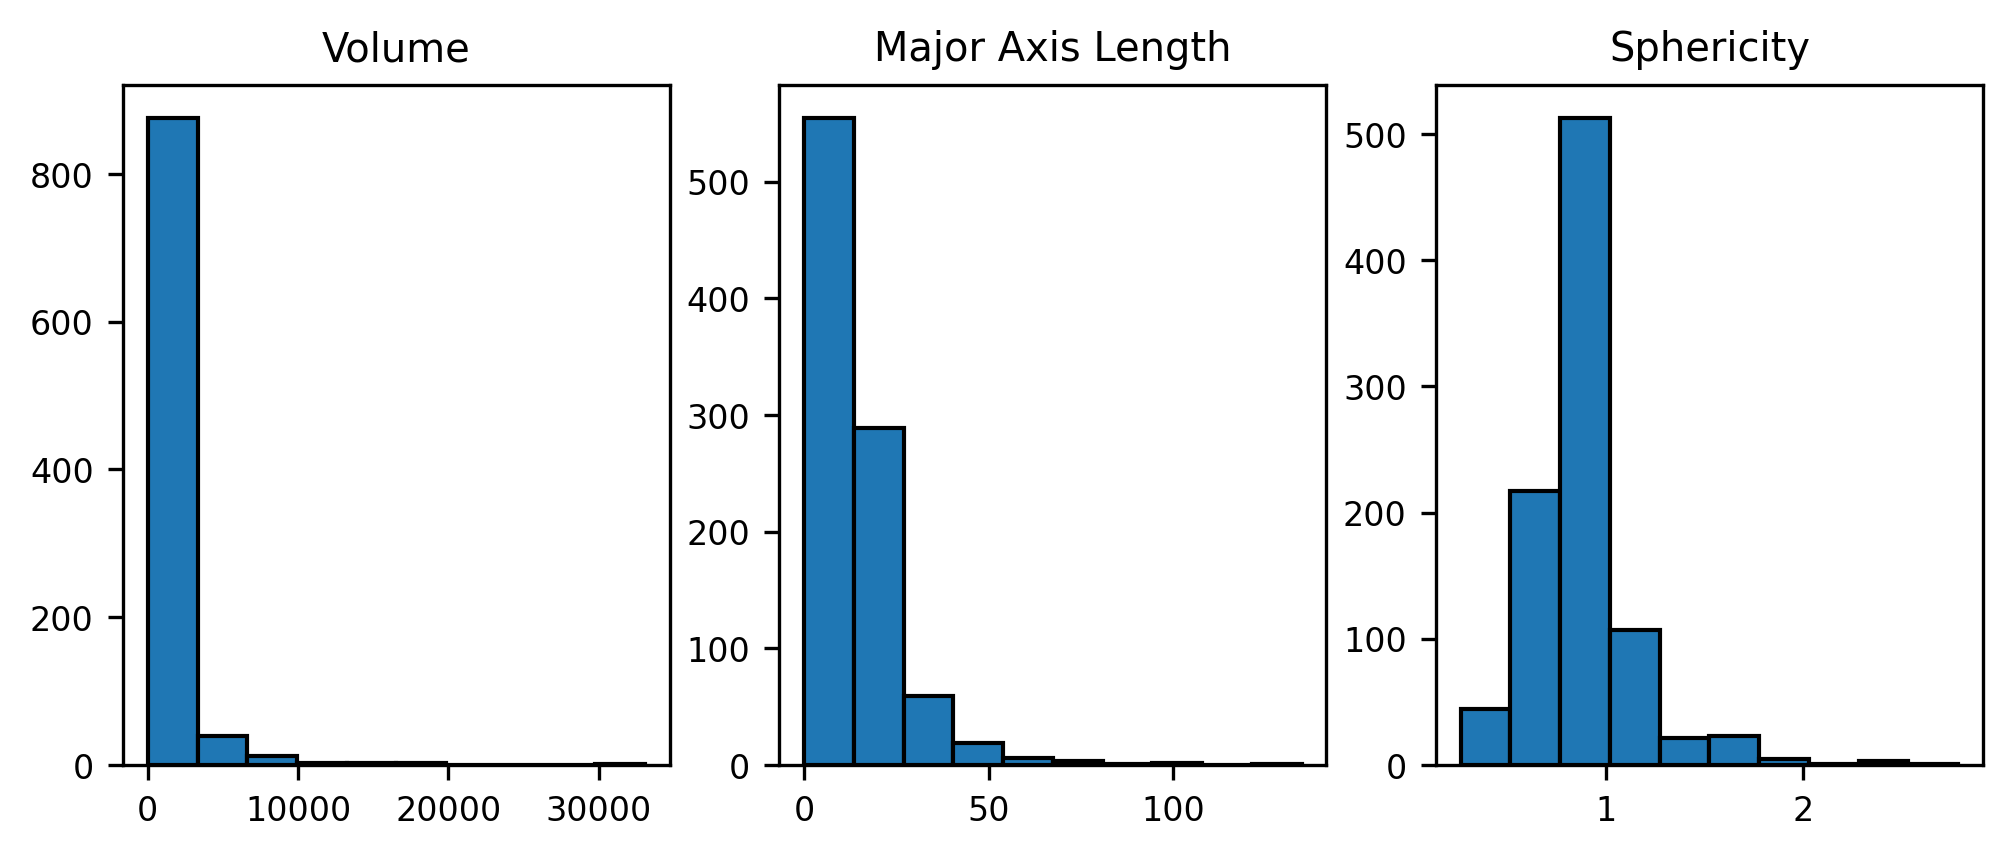

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(8, 3))
ax[0].hist(df['volume'], edgecolor="k")
ax[1].hist(df['axis_major_length'], edgecolor="k")
ax[2].hist(df['sphericity'], edgecolor="k");
ax[0].set_title("Volume")
ax[1].set_title("Major Axis Length")
ax[2].set_title("Sphericity");

#### To Do:
1. [ ] remove particles with sphericity > 1
2. [ ] remove elongated particles based on sphericity? major axis length? 
3. [ ] analyze sphericity VS particle size

![sphericity](Sphericity-of-particles-of-regular-form.png)

---
#### Some porespy stuff
- Apply_padded function

In [159]:
func = ndimage.binary_fill_holes

In [156]:
BW_pit2 = ps.filters.apply_padded(im=~BW_pit2, pad_width=1, func=func, pad_val=1)

---
#### Write tiff stack with dxchange

In [65]:
import dxchange

In [69]:
dxchange.write_tiff_stack(BW_pit_boundary, "/home/gianthk/Data/BEATS/Franceschin/20217193_Traviglia/recons/581681_punta_HR_stitch2_merge_corr_phrt/pippo/slice.tiff")